<a href="https://colab.research.google.com/github/ivarela28/Deep-Learning-with-Python/blob/master/tokenizing_embedding_text_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tokenizing and training word embeddings on IMDB movie reviews

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

##Example of using Keras Preprocessing for word-level one-hot encoding
Convert each word in samples to binary vector where all entries are zero except for ith entry, corresponding to words index in "word_index"

In [9]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

#Only use 1000 most common words
tokenizer = Tokenizer(num_words=1000)
#Builds word index in tokenizer object
tokenizer.fit_on_texts(samples)

#print(samples)
#Turns strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

#retrieve word index
word_index = tokenizer.word_index

#Result is 9 unique tokens, since "the" is repeated and "homework" is not in 1000 most common words
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


##Using word embeddings
Used instead of one-hot encoding, creates dense, low-dimensional vector representations of each word and is learned from data.

In [14]:
#vocabulary size
max_features = 10000
#cuts off samples after this many words
maxlen = 20

#load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

#"pad" shorter samples with zeroes to normalize all sample lengths.  This is required to feed it into network
#result is 2D integer tensor with shape (samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [ ]:
#Define network arcitecture
model = Sequential()
#2D integer tensor
model.add(Embedding(max_features, 8, input_length=maxlen))
#3D float tensor
model.add(Flatten())
#2D float tensor
model.add(Dense(1, activation='sigmoid'))#Classifier

#compile model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)
#result is ~75% accuracy.  Pretty good for only 20 words per sample

Result is ~75% accuracy.  Pretty good for only 20 words per sample.  However, if there is not a large number of samples to properly train the embedding, the accuracy would suffer.  In that case, you can use pre-trained embeddings

#Using pre-trained word embeddings

##Load and preprocess data

In [18]:
#Unzip raw IMDB data
#Raw IMBD data is used instead of pre-tokenized data available in Keras
#**NOTE** both dataset and embeddings must be available in mounted Google Drive
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/aclImdb.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
#Unzip Glove word embeddings
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/glove.6B.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

We must collect the individual training samples into a list of strings called 'texts', one string per sample.  Also, we collect the labels in a list of their own

In [20]:

import os

imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    #Checks that file is text file
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      #Collect sample as string
      texts.append(f.read())
      f.close()
      #Collect label as 0 for a negative review and 1 for a positive review
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

Now we can tokenize the raw data.  

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

#Cut off reviews after 100 words
maxlen = 100
#train on only 200 samples to simulate small dataset
training_samples = 200
#Validate on 10000 samples
validation_samples = 10000
#Considers only top 10000 most common words
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor: ', data.shape)
print('Shape of labels tensor: ', labels.shape)

#Shuffle the data before splitting between train and validate, because data is ordered neg then pos
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

#Split data betwen train and validate
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples : training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor:  (25000, 100)
Shape of labels tensor:  (25000,)


##Process GloVe file into usable embedding weights matrix
Now we parse the glove file to create an index that maps words (as strings) to their vector representations.

In [22]:
glove_dir = '/content'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  #Split string into list
  values = line.split()
  #isolate word
  word = values[0]
  #vectorize values
  coefs = np.asarray(values[1:], dtype='float32')
  #build index
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Create embedding weight matrix to be used in embedding layer

In [23]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

##Define network architecture and compile

In [24]:
#same model architecture
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                320032    
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


As it stands, our network's embedding layer contains randomly initialized weights.  To use our pretrained embeddings we must set the weights of that layer to the embedding matrix we constructed.  We also set that layer to be untrainable, as we do whenever pretrained weights are used

In [25]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

##Train model, Plot Results, Evaluate model

In [26]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

7/7 [==============================] - 1s 109ms/step - loss: 0.0233 - acc: 1.0000 - val_loss: 1.0312 - val_acc: 0.5366
Epoch 10/10
7/7 [==============================] - 1s 110ms/step - loss: 0.0116 - acc: 1.0000 - val_loss: 1.3513 - val_acc: 0.5181


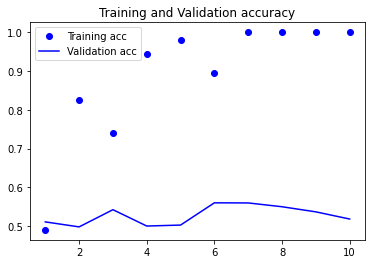

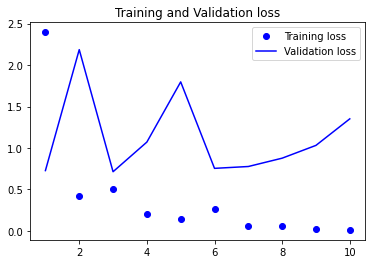

In [27]:
import matplotlib.pyplot as plt

def plot_loss_acc(stats):
  acc = stats.history['acc']
  val_acc = stats.history['val_acc']
  loss = stats.history['loss']
  val_loss = stats.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and Validation accuracy')
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()

  plt.show()

plot_loss_acc(history)

The model quickly overfits, unsurprising for the small amount of data.  For completeness, we evaluate the model on the test set

In [28]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(test_dir, label_type)
  for fname in sorted(os.listdir(dir_name)):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [29]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 1.3510 - acc: 0.5215


[1.3510477542877197, 0.5214800238609314]